# Intrusion Detection System

- In this project we will be trying to evaluate the performance of Shallow Neural Networks on the `CSE-CIC-IDS2018 on AWS` dataset
- Here we are working on a curated smaller dataset due to computational limitations
- We have created a smaller subset of the overall dataset with a total 1.2 lakhs+ records

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer

### Getting to know our data

- After importing our data we will seperate feature columns to form the X and Y labels
- Then we will use `sklearn` library functions to split data into training and testing sets

In [2]:
train=pd.read_csv(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\train.csv")
test=pd.read_csv(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\test.csv")

In [3]:
train.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
y_values={
    "BENIGN": 0,
    "DDoS": 1,
    "PortScan": 2,
    "FTP-Patator": 3,
    "SSH-Patator": 4,
    "DoS slowloris": 5,
    "DoS Slowhttptest": 6,
    "DoS Hulk": 7,
    "DoS GoldenEye": 8,
}

In [19]:
train=train[train.iloc[:,-1].isin(y_values.keys())]
test=test[test.iloc[:,-1].isin(y_values.keys())]

In [20]:
X_train=train.iloc[:,0:-1]
Y_train=train.iloc[:,-1].map(y_values)
X_test=test.iloc[:,0:-1]
Y_test=test.iloc[:,-1].map(y_values)

In [21]:
X_train.fillna(value=0,inplace=True)
X_train.replace([np.inf],0,inplace=True)
X_test.fillna(value=0,inplace=True)
X_test.replace([np.inf],0,inplace=True)

In [22]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [23]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(468336, 78) (468336,)
(117087, 78) (117087,)


### Model Acrhitecture

- Dense layer with 1024 units and activation `relu`
- Dense layer with 1024 units and activation `relu`
- Dense layer with 128 units and activation `relu`
- Dense layer with 10 units and activation `softmax`

### Compile metrics

- Used metrics are:
    - Accuracy
- Optimizer used:
    - Adam
- Cost Function used:
    - SparseCategoricalCrossEntropy

In [25]:
initializer=tf.keras.initializers.RandomNormal(seed=1)

model=tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(78,)),
    tf.keras.layers.Dense(units=1024,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001),kernel_initializer=initializer),
    tf.keras.layers.Dense(units=1024,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001),kernel_initializer=initializer),
    tf.keras.layers.Dense(units=128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001),kernel_initializer=initializer),
    tf.keras.layers.Dense(units=9,activation='linear',kernel_regularizer=tf.keras.regularizers.L2(0.001),kernel_initializer=initializer)
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              80896     
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dense_7 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 1,262,857
Trainable params: 1,262,857
Non-trainable params: 0
_________________________________________________________________


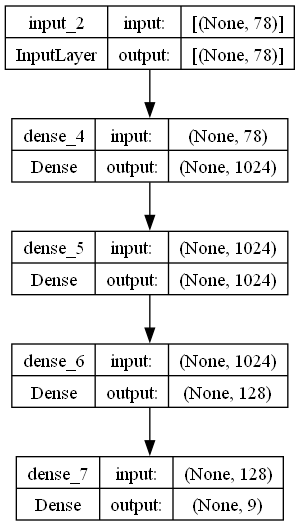

In [27]:
tf.keras.utils.plot_model(model,to_file="Softmax_dense_model.png",show_shapes=True)

### Normalization

- Normalization is process in which we rescale our data for faster computation
- Here we will be using z-score-normalization by implementing `StandardScaler` on the train data 

In [28]:
scaler=QuantileTransformer()
scaler.fit_transform(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Callbacks

- Callbacks can be utilized for premature termination of training
- Based on conditions, we can set the `self.model.stop_training` boolean to `True`
- The conditions can be checked based on real time data from the `logs` parameter that hold the values of loss and other metrics that were configured into the model during the compile statement

In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.prev_loss=0
    def on_epoch_end(self,epoch,logs={}):
        model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/DNN models/model_{epoch}.h5")
        if(epoch>0 and logs.get('loss')>self.prev_loss):
            print('\nLearning rate updated')
            self.model.optimizer.lr.assign(self.model.optimizer.lr.read_value()*0.1)
        self.prev_loss=logs.get('loss')

callbacks=myCallback()

Fit data to the model

In [30]:
history=model.fit(X_train_scaled,Y_train,epochs=20,validation_data=(X_test_scaled,Y_test),callbacks=[callbacks])

Epoch 1/20
14636/14636 [==============================] - 154s 10ms/step - loss: 0.3605 - accuracy: 0.9850 - val_loss: 0.1423 - val_accuracy: 0.9905
Epoch 2/20
14636/14636 [==============================] - 136s 9ms/step - loss: 0.1268 - accuracy: 0.9914 - val_loss: 0.1262 - val_accuracy: 0.9903
Epoch 3/20
14636/14636 [==============================] - 136s 9ms/step - loss: 0.1171 - accuracy: 0.9917 - val_loss: 0.1192 - val_accuracy: 0.9888
Epoch 4/20
14636/14636 [==============================] - 178s 12ms/step - loss: 0.1133 - accuracy: 0.9920 - val_loss: 0.1248 - val_accuracy: 0.9887
Epoch 5/20
14636/14636 [==============================] - 172s 12ms/step - loss: 0.1115 - accuracy: 0.9922 - val_loss: 0.1168 - val_accuracy: 0.9884
Epoch 6/20
14636/14636 [==============================] - 169s 12ms/step - loss: 0.1104 - accuracy: 0.9924 - val_loss: 0.1187 - val_accuracy: 0.9886
Epoch 7/20
14636/14636 [==============================] - 166s 11ms/step - loss: 0.1096 - accuracy: 0.9924 -

In [31]:
# Emergency Save
model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/DNN models/model_{20}.h5")

In [32]:
import json

with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/DNN.txt","w") as file:
    file.write(json.dumps(history.params))
with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/DNN_history.txt","w") as file:
    file.write(json.dumps(history.history))

In [33]:
model=tf.keras.models.load_model(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/DNN models/model_{19}.h5")

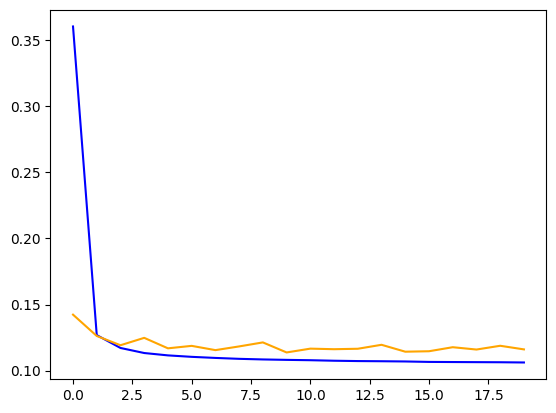

In [34]:
plt.plot(range(20),history.history["loss"],color="blue",label="Train Loss")
plt.plot(range(20),history.history["val_loss"],color="orange",label="Validation Loss")
plt.show()

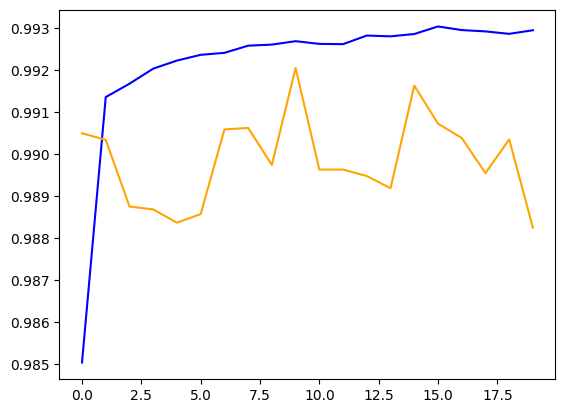

In [35]:
plt.plot(range(20),history.history["accuracy"],color="blue",label="Train Accuracy")
plt.plot(range(20),history.history["val_accuracy"],color="orange",label="Validation Accuracy")
plt.show()

Evaluate the metrics for each set

In [36]:
model.evaluate(X_train_scaled,Y_train)
model.evaluate(X_test_scaled,Y_test)

3659/3659 [==============================] - 20s 6ms/step - loss: 0.1160 - accuracy: 0.9882


[0.11603362113237381, 0.9882480502128601]

In [37]:
y_predict=tf.nn.softmax(model.predict(X_test_scaled))
y_predict.shape

3659/3659 [==============================] - 11s 3ms/step


TensorShape([117087, 9])

In [38]:
y_predict=np.argmax(y_predict,axis=1)
y_predict.shape

(117087,)

In [43]:
confusion_matrix=tf.math.confusion_matrix(Y_test,y_predict)
confusion_matrix

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[79835,     3,     0,     0,    85,     0,     9,    68,     0],
       [   13,  9987,     0,     0,     0,     0,     0,     0,     0],
       [   12,     0,  9988,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,  1576,     0,     1,     0,    11,     0],
       [    1,     0,     0,     0,  1175,     0,     0,     4,     0],
       [   65,     0,     0,     0,     0,   732,   363,     0,     0],
       [    8,     0,     0,     0,    17,    21,  1054,     0,     0],
       [  489,     0,     0,     0,     0,     0,     0,  9510,     1],
       [  184,     1,     0,     0,     0,     5,     0,    15,  1854]])>

In [46]:
from mlxtend.plotting import plot_confusion_matrix

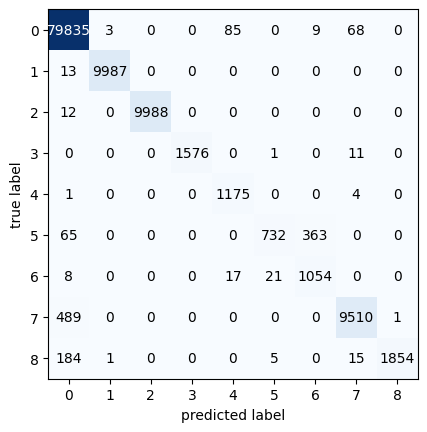

In [52]:
fig,ax=plot_confusion_matrix(confusion_matrix.numpy())
plt.show()

In [40]:
pd.DataFrame(Y_test[np.where(y_predict!=Y_test)]).value_counts()

7    490
5    428
8    205
0    165
6     46
1     13
2     12
3     12
4      5
Name: count, dtype: int64

In [41]:
pd.DataFrame(y_predict[np.where(y_predict!=Y_test)]).value_counts()

0    772
6    372
4    102
7     98
5     27
1      4
8      1
Name: count, dtype: int64